In [1]:
import sys
sys.path.append("../../")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.image as mpimg
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import h5py
#from tqdm.keras import TqdmCallback
from transport_nets.models.NVP import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# visualizing joint distribution p(m,y) where 
# dim(m) = 3, dim(y) = 6
file = h5py.File('BeamSamples.h5','r')
joint_samps = np.array(file['Samples/'],dtype=np.float32)
# Put the target data in a format the tf likes.
NUM_SAMPLES = joint_samps.shape[0]
BATCH_SIZE = 50
dataset = tf.data.Dataset.from_tensor_slices(joint_samps)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

NUM_MASKED = 4
OUTPUT_DIM = 9
NUM_LAYERS = 6
NEURON_LIST = [50,50]

nvp = NVP(NUM_MASKED,OUTPUT_DIM,NUM_LAYERS,NEURON_LIST)

# Adam optimizer parameters
LR = 1e-5
beta_1 = 0.9
beta_2 = 0.999
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=beta_1, beta_2=beta_2, epsilon=1e-08)
nvp.compile(opt)

N_EPOCHS = 50
# Train the model with the new callback
history = nvp.fit(dataset, epochs=N_EPOCHS)  # Pass callback to training
# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
1000/1000 [==============================] - 3s 3ms/step - Negative Log Likelihood: -2.5523
Epoch 2/50
1000/1000 [==============================] - 3s 3ms/step - Negative Log Likelihood: -8.6326
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - Negative Log Likelihood: -12.6117
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - Negative Log Likelihood: -15.2230
Epoch 5/50
1000/1000 [==============================] - 4s 4ms/step - Negative Log Likelihood: -16.8405
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - Negative Log Likelihood: -17.9264
Epoch 7/50
1

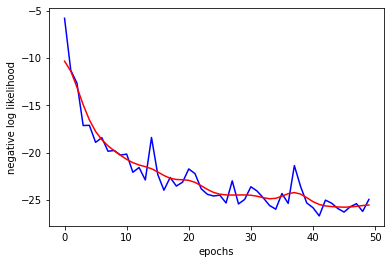

In [3]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood');

<Figure size 1080x1080 with 0 Axes>

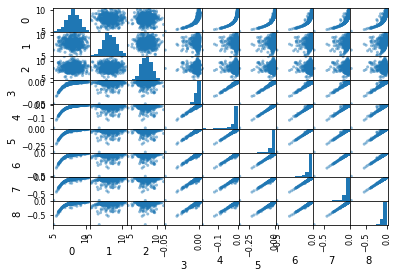

In [4]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(joint_samps[::100,:]))
plt.savefig('Euler-Beam-joint-density-samples.png')
plt.show()

<Figure size 1080x1080 with 0 Axes>

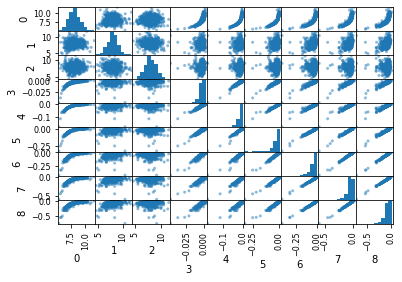

In [5]:
fig = plt.figure(figsize=(15,15))
x_forward = nvp.sample(500).numpy()
scatter_matrix(pd.DataFrame(x_forward))
plt.savefig('Euler-Beam-joint-density-nvp.png')
plt.show()

In [6]:
# finding where inf values are
#inf_ind = tf.where(tf.math.is_inf(x_forward[10:,])==True).numpy()
#print(inf_ind)

### Algorithm 1 RTO Metropolis–Hastings (RTO-MH)

1. Find $v_{ref}$ using (3)  

$$(3)\qquad v_{ref} = arg \min_{v} \frac{1}{2} ||H(v)||^2 $$

2. Determine $\nabla H(v_{ref})$
3. Compute Q, whose columns are an orthonomal basis for the range of $\nabla H(v_{ref})$
4. for $i=1,...,n_{samps}$ do in parallel
5. &nbsp;&nbsp;&nbsp;&nbsp; Sample $\eta^{(i)}$ from an (n+m) dimensional standard normal distribution
6. &nbsp;&nbsp;&nbsp;&nbsp; Solve for a proposal sample $v_{prop}^{(i)}$ using (5)
7. &nbsp;&nbsp;&nbsp;&nbsp; Compute $w(v_{prop}^{(i)})$ from (8)

$$(5) \qquad v_{prop}^{(i)} = arg \min_{v} \frac{1}{2}\left|\left|Q^T(H(v)-\eta^{(i)})\right|\right|^{\ 2}$$

$$(8) \qquad w(v) = |det(Q^T \nabla H(v))|^{-1}exp\left(-\frac{1}{2}||H(v)||^2 + \frac{1}{2}||Q^TH(v)||^2\right)$$

8. Set $v^{(0)} = v_{ref}$
9. for $i=1,...,n_{samps}$ do in series
10. &nbsp;&nbsp;&nbsp;&nbsp; Sample $t$ from a uniform distribution on $[0,1]$
11. &nbsp;&nbsp;&nbsp;&nbsp; if $t < w(v_{prop}^{(i)})\ /\ w(v^{i-1})$ then
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v^{(i)} = v_{prop}^{(i)}$
13. &nbsp;&nbsp;&nbsp;&nbsp; else
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v^{(i)} = v^{(i-1)}$

In [7]:
# try for a single sample m ~ p(m|y)
# compare generative model with true model 
t0 = time.time()
n = 9 # dimensionality of m + y
m = 6 # dimensionality of y
y_s = n-m #start of y vector 
m_y_obs = joint_samps[0,:]
y = np.reshape(m_y_obs[y_s:],(1,-1)) # observed displacement for p(m|y=y*)
noiseStd = 1e-3 #observational noise added to original training data
S_obs_inv_transpose = tf.transpose(tf.linalg.inv(noiseStd*tf.eye(m)))
vi = tf.random.normal([1,n],stddev=0.1)

@tf.function
def G(v,S_obs_inv_transpose=S_obs_inv_transpose):
    # defining matrix operations reverse of actual equation in order to allow for batch ops 
    return (nvp(v)[:,y_s:]-y)@S_obs_inv_transpose
@tf.function
def H(v):
    return tf.concat([v,G(v)],-1)
@tf.function
def H_loss_and_gradient(v):
    return tfp.math.value_and_gradient(
        lambda v: 0.5*tf.norm(H(v),axis=-1)**2, v)

# minimizing (3)
opt_results = tfp.optimizer.bfgs_minimize(
                H_loss_and_gradient, initial_position=vi, tolerance=1e-6)
v_ref = opt_results.position

# going to use tf.batch_jacobian
# jacobian of H wrt v_ref
@tf.function
def Jac_H(v):
    with tf.GradientTape() as g:
        g.watch(v)
        f = H(v)
    batch_jac = g.batch_jacobian(f,v)
    return batch_jac

jac_H = Jac_H(v_ref)[0,...]   

Q,R = tf.linalg.qr(jac_H)
@tf.function
def v_prop_loss_and_gradient(v):
    return tfp.math.value_and_gradient(
        lambda v: 0.5*tf.norm(Q_T@tf.reshape(H(v)-eta,[-1,m+n,1]),axis=[-2,-1])**2, v)

N_samps = 1000
eta = tf.random.normal(shape=[N_samps,n+m])
Q_T = tf.transpose(Q)
vi = tf.random.normal([N_samps,n],stddev=0.1)

v_prop_opt = tfp.optimizer.bfgs_minimize(
                v_prop_loss_and_gradient, initial_position=vi, tolerance=1e-6)
v_prop = v_prop_opt.position
@tf.function
def w(v):
    A = tf.abs(tf.linalg.det(Q_T@Jac_H(v)))**(-1)
    x1 = -0.5*tf.norm(H(v),axis=-1)**2
    x2 = 0.5*tf.norm(Q_T@tf.reshape(H(v),[-1,m+n,1]),axis=[-2,-1])**2
    return A*tf.exp(x1+x2)

w_v_prop = w(v_prop)

v_samps = np.zeros([N_samps,n])
v_samps[0,:] = v_ref
n_acc = 0
for i in range(1,N_samps):
    t = tf.random.uniform(shape=[1])
    v = tf.reshape(tf.constant(v_samps[i-1,:],dtype=tf.float32),[1,n])
    if t < w_v_prop[i]/w(v):
        v_samps[i,:] = v_prop[i,:].numpy()
        n_acc += 1
    else:
        v_samps[i,:] = v_samps[i-1,:]
t1 = time.time()
print('Acceptance Rate:',n_acc/N_samps)
print('time:',t1-t0)

X_cond = nvp(v_samps).numpy()

Acceptance Rate: 0.166
time: 14.509130716323853

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



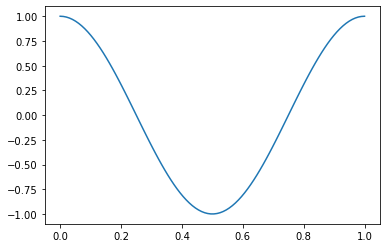

In [10]:
x = np.linspace(0,1,100)
y = np.cos((2*np.pi*x)/1.0)
plt.plot(x,y)

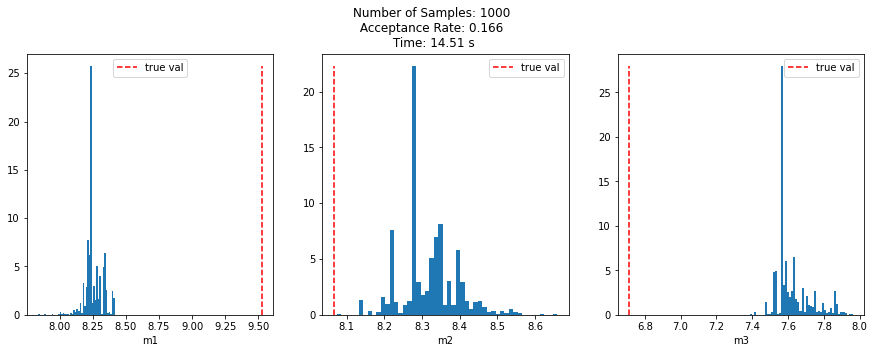

In [8]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(m_y_obs[:y_s])
counts,bins = np.histogram(X_cond[:,0],50,density=True)
axs[0].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m1,m1,100)
y = np.linspace(0,max(counts),100)
axs[0].plot(x,y,'r--',label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()
counts,bins = np.histogram(X_cond[:,1],50,density=True)
axs[1].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m2,m2,100)
y = np.linspace(0,max(counts),100)
axs[1].plot(x,y,'r--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()
counts,bins = np.histogram(X_cond[:,2],50,density=True)
plt.hist(bins[:-1],bins,weights=counts)
x = np.linspace(m3,m3,100)
y = np.linspace(0,max(counts),100)
axs[2].plot(x,y,'r--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()
plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(N_samps,n_acc/N_samps,t1-t0))
plt.subplots_adjust(top=0.85)

plt.savefig('Euler_Beam_MCMC_samples.png')
plt.savefig('Euler_Beam_RTO_MH_samples_1e-2_obs_noise.png')